<a href="https://colab.research.google.com/github/Svetorus/Recomen_systems/blob/master/RS_HW_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [ ]:
#!pip install implicit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [ ]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


/home/alex/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
recommender = MainRecommender(data_train_lvl_1)

In [ ]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 1079023, 1046545, 1004906]

In [ ]:
recommender.get_own_recommendations(2375, N=5)

[1036501, 1079023, 1085983, 907099, 910439]

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

[868764, 889731, 1055646, 1046545, 981760]

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

[869195, 962199, 6979427, 894439, 822677]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
# your_code

In [ ]:
np.setdiff1d(data_val_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()

[1984]

In [ ]:
users_train_lvl_1 = data_train_lvl_1['user_id'].unique()

In [ ]:
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(users_train_lvl_1)]

In [ ]:
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


Отбор кандидатов

In [ ]:
%%time
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

CPU times: user 1min 36s, sys: 6.29 s, total: 1min 42s
Wall time: 30.7 s


In [ ]:
%%time
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

CPU times: user 9.58 s, sys: 116 ms, total: 9.7 s
Wall time: 9.5 s


In [ ]:
%%time
result_lvl_1['similar_items_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))


CPU times: user 43.3 s, sys: 1.34 s, total: 44.6 s
Wall time: 12.3 s


In [ ]:
# result_lvl_1['similar_users_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))
# падает с ошибкой "userid is out of bounds of the user_items matrix"

In [ ]:
rec_dict = {
            'ALS' : 0,
            'OWN' : 0,
            'SIM_ITEMS' : 0
            }

In [ ]:
rec_dict['ALS'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual']), axis=1).mean()
rec_dict['OWN'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()
rec_dict['SIM_ITEMS'] = result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendations'], row['actual']), axis=1).mean()

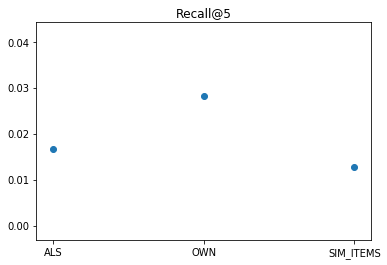

In [ ]:
fig, ax = plt.subplots()
ax.scatter(rec_dict.keys(), rec_dict.values())
ax.set_title('Recall@5');

как мы видим,кандидаты отобранные с помощью own recommendtions + top-popular дают лучший recall

## B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}

In [ ]:
k_numbers = [5, 20, 50, 100, 200, 500]
k_candidates = [20, 50, 100, 200, 500]

In [ ]:
rec_dict_1 = {}

In [ ]:
for n_candidates in k_candidates:
  res_list = []
  result_lvl_1[f'own_recommendations_{n_candidates}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=n_candidates))

  for n_numbers in k_numbers:
    prec = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_recommendations_{n_candidates}'], row['actual'], k=n_numbers), axis=1).mean()
    res_list.append(prec)
  rec_dict_1[f'{n_candidates}'] = res_list

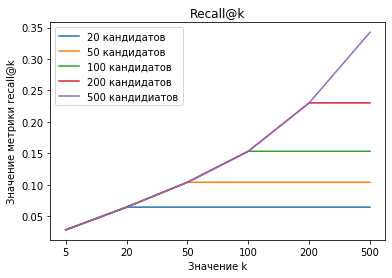

In [ ]:
fig, ax = plt.subplots()

plt.xticks(range(6), [5, 20, 50, 100, 200, 500])

for key in rec_dict_1:
    ax.plot(rec_dict_1[key])

ax.set_xlabel('Значение k')
ax.set_ylabel('Значение метрики recall@k')
ax.set_title('Recall@k')
plt.legend(['20 кандидатов', '50 кандидатов', '100 кандидатов', '200 кандидатов', '500 кандидиатов']);

## C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Судя по всему, наиболее разумным является значение k меньше или равное количеству кандидатов

### Задание 2.

Обучите модель 2-ого уровня, при этом:  
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар  
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2  
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [ ]:
# your_code

users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [ ]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[834103, 878302, 1119399, 1085604, 13511722, 9..."
1,2021,"[1119454, 1019142, 871279, 835578, 863762, 101..."


In [ ]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,834103,1
0,2070,878302,1
0,2070,1119399,1
0,2070,1085604,1


In [ ]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [ ]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0
2,2070,834103,1.0
3,2070,834103,1.0
4,2070,834103,1.0


In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [ ]:
targets_lvl_2.shape

(115495, 16)

In [ ]:
big_data = data.merge(item_features, on='item_id', how='left')
big_data = big_data.merge(user_features, on='user_id', how='left')

In [ ]:
big_data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,...,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,...,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Фичи товара

Кол-во покупок в неделю, среднее кол-во покупок в неделю по каждой категории товара

In [ ]:
temp_df = big_data.groupby('department').agg({'quantity' : 'sum'}).reset_index()
# создаем временный датафрейм, в котором будут значения количеств всех покупок по каждой категории

In [ ]:
temp_df.head()

,department,quantity
0,,0
1,AUTOMOTIVE,61
2,CHARITABLE CONT,3
3,CHEF SHOPPE,754
4,CNTRL/STORE SUP,22


In [ ]:
temp_df['average_num_purchases_per_week'] = temp_df['quantity'] / big_data['week_no'].nunique()
# теперь делим количество покупок на количество недель и получаем среднее количество покупок в неделю для каждой категории товара

In [ ]:
temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_per_week'})

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['department'], how='left')
# объединяем обучающий датасет и фичи по категориям

In [ ]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,num_purchases_per_week,average_num_purchases_per_week
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263


## Фичи пользователя¶

Средний чек

In [ ]:
temp_df = pd.DataFrame()

In [ ]:
temp_df = big_data[['user_id', 'basket_id', 'quantity', 'sales_value', 'department']]

In [ ]:
temp_df.head(2)

,user_id,basket_id,quantity,sales_value,department
0,2375,26984851472,1,1.39,PRODUCE
1,2375,26984851472,1,0.82,PRODUCE


In [ ]:
temp_df['amount'] = temp_df['quantity'] * temp_df['sales_value']
# считаем сумму по каждому товару

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp_df = temp_df.groupby(['user_id'])['basket_id'].count().reset_index().merge(
    temp_df.groupby(['user_id']).agg({'amount' : 'sum'}), on='user_id', how='left')
# получаем количество заказов пользователя и общую сумму всех заказов

In [ ]:
temp_df['average_check'] = temp_df['amount'] / temp_df['basket_id']

In [ ]:
temp_df.head()

,user_id,basket_id,amount,average_check
0,1,1589,4928.19,3.101441
1,2,655,2210.50,3.374809
2,3,889,144547.93,162.596097
3,4,301,1747.05,5.804153
4,5,219,829.08,3.785753


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(temp_df[['user_id', 'average_check']], on=['user_id'], how='left')
# объединяем обучающий датасет и фичи

Кол-во покупок в каждой категории

In [ ]:
temp_df = big_data[['user_id', 'quantity', 'department']]

In [ ]:
temp_df = temp_df.groupby(['user_id', 'department']).agg({'quantity' : 'sum'}).reset_index()
# получаем количество покупок по каждой категории товара


In [ ]:
temp_df = temp_df.rename(columns={'quantity' : 'num_purchases_each_department'})

In [ ]:
temp_df.head()

,user_id,department,num_purchases_each_department
0,1,,0
1,1,DELI,58
2,1,DRUG GM,176
3,1,FLORAL,1
4,1,GROCERY,1229


In [ ]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department'], how='left')
# объединяем обучающий датасет и фичи

In [ ]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,num_purchases_per_week,average_num_purchases_per_week,average_check,num_purchases_each_department
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2025562,21321.705263,1105.636389,2216.0


## Фичи пары user_id - item_id

Средняя сумма покупки 1 товара в каждой категории

In [ ]:
temp_df = pd.DataFrame()

In [ ]:
temp_df= big_data[['user_id', 'item_id', 'department', 'quantity', 'sales_value']]

In [ ]:
temp_df['summ'] = temp_df['quantity'] * temp_df['sales_value']

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
temp_df.head(2)

,user_id,item_id,department,quantity,sales_value,summ
0,2375,1004906,PRODUCE,1,1.39,1.39
1,2375,1033142,PRODUCE,1,0.82,0.82


In [ ]:
# считаем среднюю сумму покупки товара в каждой категории
temp_df_1 = temp_df.groupby(['user_id', 'department']).agg({'summ' : 'mean'})\
            .rename(columns={'summ' : 'mean_summ'})\
            .reset_index()
temp_df_1.head(2)

,user_id,department,mean_summ
0,1,,0.000000
1,1,DELI,3.091897


In [ ]:
temp_df = temp_df.merge(temp_df_1, on=['user_id', 'department'], how='left')
temp_df.head(2)

,user_id,item_id,department,quantity,sales_value,summ,mean_summ
0,2375,1004906,PRODUCE,1,1.39,1.39,8.40978
1,2375,1033142,PRODUCE,1,0.82,0.82,8.40978


In [ ]:
temp_df['price_item_minus_mean_summ'] = temp_df['sales_value'] - temp_df['mean_summ']

In [ ]:
temp_df.head(2)

,user_id,item_id,department,quantity,sales_value,summ,mean_summ,price_item_minus_mean_summ
0,2375,1004906,PRODUCE,1,1.39,1.39,8.40978,-7.01978
1,2375,1033142,PRODUCE,1,0.82,0.82,8.40978,-7.58978


In [ ]:
users_in_targets_lvl_2 = targets_lvl_2['user_id'].unique()

In [ ]:
items_in_targets_lvl_2 = targets_lvl_2['item_id'].unique()

In [ ]:
temp_df = temp_df[(temp_df['user_id'].isin(users_in_targets_lvl_2)) & (temp_df['item_id'].isin(items_in_targets_lvl_2))]

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department', 'item_id'], how='left')
# объединяем обучающий датасет и фичи

In [ ]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,kid_category_desc,num_purchases_per_week,average_num_purchases_per_week,average_check,num_purchases_each_department,quantity,sales_value,summ,mean_summ,price_item_minus_mean_summ
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,None/Unknown,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,None/Unknown,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662


(Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

In [ ]:
big_data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,VEGETABLES - ALL OTHERS,CELERY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
temp_df_1 = big_data.groupby(['user_id', 'department', 'week_no']).agg({'quantity' : 'mean'})\
                    .reset_index()\
                    .rename(columns={'quantity' : 'sum_quantity_per_week_per_user_per_dept'})
temp_df_1.head(2)

,user_id,department,week_no,sum_quantity_per_week_per_user_per_dept
0,1,,14,0.0
1,1,,28,0.0


In [ ]:
temp_df_2 = big_data.groupby(['department', 'week_no']).agg({'quantity' : 'sum'})\
                    .reset_index()\
                    .rename(columns=({'quantity' : 'mean_quantyity_per_week_per_dept'}))
temp_df_2.head(2)

,department,week_no,mean_quantyity_per_week_per_dept
0,,1,0
1,,2,0


In [ ]:
temp_df = temp_df_1.merge(temp_df_2, on=['department', 'week_no'], how='left')
temp_df.head(2)

,user_id,department,week_no,sum_quantity_per_week_per_user_per_dept,mean_quantyity_per_week_per_dept
0,1,,14,0.0,0
1,1,,28,0.0,0


In [ ]:
temp_df['sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept'] = \
    temp_df['sum_quantity_per_week_per_user_per_dept'] - temp_df['mean_quantyity_per_week_per_dept']
temp_df.head()

,user_id,department,week_no,sum_quantity_per_week_per_user_per_dept,mean_quantyity_per_week_per_dept,sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept
0,1,,14,0.0,0,0.0
1,1,,28,0.0,0,0.0
2,1,,38,0.0,0,0.0
3,1,,42,0.0,0,0.0
4,1,,52,0.0,0,0.0


In [ ]:
temp_df.head(2)

,user_id,department,week_no,sum_quantity_per_week_per_user_per_dept,mean_quantyity_per_week_per_dept,sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept
0,1,,14,0.0,0,0.0
1,1,,28,0.0,0,0.0


In [ ]:
temp_df = temp_df[(temp_df['user_id'].isin(targets_lvl_2['user_id'].unique()))]\
        [['user_id', 'department', 'sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept']]
temp_df.head(2)

,user_id,department,sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept
0,1,,0.0
1,1,,0.0


In [ ]:
temp_df = temp_df.groupby(['user_id', 'department'])\
       .agg({'sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept' : 'mean'})\
       .reset_index()

In [ ]:
targets_lvl_2 = targets_lvl_2.merge(temp_df, on=['user_id', 'department'], how='left')
# объединяем обучающий датасет и фичи

In [ ]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,num_purchases_per_week,average_num_purchases_per_week,average_check,num_purchases_each_department,quantity,sales_value,summ,mean_summ,price_item_minus_mean_summ,sum_quantity_per_week_per_user_per_dept_minus_mean_quantyity_per_week_per_dept
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662,-23409.825261
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662,-23409.825261
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662,-23409.825261
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662,-23409.825261
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,2025562,21321.705263,1105.636389,2216.0,1.0,1.29,1.29,4.134662,-2.844662,-23409.825261


## Модель

In [ ]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [ ]:
cat_feats = X_train.columns[2:-10].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [ ]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/alex/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [ ]:
train_preds.shape

(676710,)

In [ ]:
np.unique(train_preds)

array([0., 1.])

Фичи user_id:

- Средний чек
- Средняя сумма покупки 1 товара в каждой категории
- Кол-во покупок в каждой категории
- Частотность покупок раз/месяц
- Долю покупок в выходные
- Долю покупок утром/днем/вечером

Фичи item_id:

- Кол-во покупок в неделю
- Среднее кол-во покупок 1 товара в категории в неделю
- (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
- Цена (Можно посчитать из retil_train.csv)
- Цена / Средняя цена товара в категории

Фичи пары user_id - item_id

- (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
- (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
- (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)